In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sn

# 1. Visualisation des données

In [2]:
globalVisionData = pd.read_csv('data/train.csv')
display(globalVisionData.head())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
globalVisionData.shape

(10886, 12)

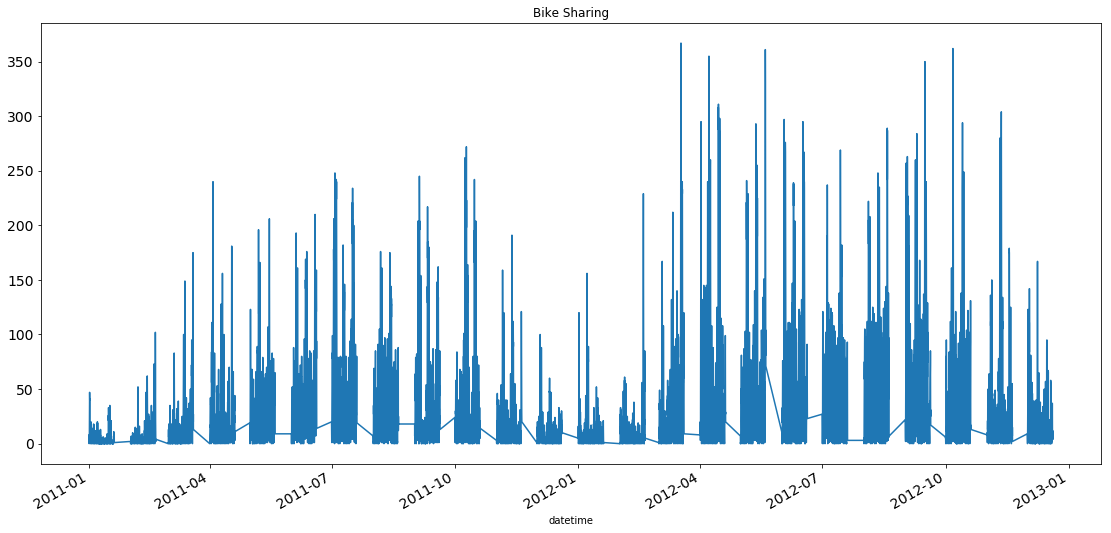

In [4]:
globalVisionData.datetime = pd.to_datetime(globalVisionData.datetime)
globalVisionData.index = globalVisionData.datetime

globalVisionData.casual.plot(figsize=(19,9), title="Bike Sharing", fontsize=14)
plt.show()

# 2. Transformation des données

##   2.1. Importation des données

In [5]:
dataTrain = pd.read_csv('data/train.csv') # 1 au 19 du mois (avec count)
dataTest = pd.read_csv('data/test.csv') # 19 à fin du mois (sans count)

`data` va correspondre à la concaténation de `dataTrain` et `dataTest` (soit l'ensemble des dates).

In [6]:
data = dataTrain.append(dataTest)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

/home/corentin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## 2.2. Ajouts de nouvelles colonnes

La date va être découpée en plusieurs colonnes correspondantes chacunes à une unité temporelle

In [7]:
import calendar
from datetime import datetime

data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

## 2.3. Classification des attributs

Nous avons donc 3 types de valeurs différentes:
- Les attributs que l'on nomme `categoricalAttributeNames`: ce sont des entiers qui représentent des catégories (par exemple, season=1 représente le premier quart de l'année).
- les attributs numériques que l'on nomme `numericalAttributeNames`: ce sont des float qui représente une mesure numérique.
- les attributs qu'on ne souhaite pas conserver dans l'entrainement du model (que l'on nomme) `dropAttributes` car:
    - ce sont les attributs que l'on souhaite prédire (l'attribut count)
    - ce sont des attributs redondants (par exemple datetime)

In [8]:
categoricalAttributeNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalAttributeNames = ["temp","humidity","windspeed","atemp"]
dropAttributes = ["casual","count","datetime","date","registered"]

print(data.dtypes)

atemp         float64
casual        float64
count         float64
datetime       object
holiday         int64
humidity        int64
registered    float64
season          int64
temp          float64
weather         int64
windspeed     float64
workingday      int64
date           object
hour            int64
year           object
weekday         int64
month           int64
dtype: object


Via la librairie `pandas`, on cast le type d'attribut vers `category` pour tous les attributs de la liste `categoricalAttributeNames`

In [9]:
for var in categoricalAttributeNames:
    data[var] = data[var].astype("category")

# 3. Prédiction

## 3.1. RMSLE Scorer

Afin de juger de la qualité de nos prédictions pour chacun des différents modèles, on définit un RSMLE scorer :

In [10]:
def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

Ce scorer exprime de la valeur de la dissimilarité entre notre prédiction (attribut `y`) et les valeurs réelles (attribut `y_`).

## 3.2. Séparation des données d'entraînement et de test 

Pour entrainer le modèle, on re-divise `data` en `dataTrain` (là où on connait l'attribut count) et `dataTest` (là où on doit prédire l'attribut count)

In [11]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])

## 3.3. Division des données pour apprentissage suppervisé

On souhaite mettre en place un apprentissage supervisé.
Ainsi, on divise `dataTrain` de cette façon :
    - 70% pour l'entraînement
    - 30% pour la validation 
    
On utilise scikit-learn et la fonction `train_test_split()` pour séparer ces données.

In [12]:
from sklearn.model_selection import train_test_split

### 3.3.1. Division pour l'attribut casual

In [13]:
X_train_casual, X_validate_casual, y_train_casual, y_validate_casual = train_test_split(dataTrain, dataTrain["casual"], test_size=0.3, random_state=23)
X_train_casual = X_train_casual.drop(dropAttributes,axis=1)

### 3.3.2. Division pour l'attribut registered

In [14]:
X_train_regis, X_validate_regis, y_train_regis, y_validate_regis = train_test_split(dataTrain, dataTrain["registered"], test_size=0.3, random_state=23)
X_train_regis = X_train_regis.drop(dropAttributes,axis=1)

## 3.3. Suppression de colonnes

In [15]:
dataTest = dataTest.drop(dropAttributes,axis=1)
X_validate_casual = X_validate_casual.drop(dropAttributes,axis=1)
X_validate_regis = X_validate_regis.drop(dropAttributes,axis=1)

## 3.4 Création du Modèle de régression logistique

In [16]:
from sklearn.ensemble import RandomForestRegressor

### 3.4.1 Attribut casual

In [26]:
# Initialisation du modèle
rfModelCasual = RandomForestRegressor()

# Entrainement du modèle sur 70% pour casual
rfModelCasual.fit(X = X_train_casual,y = y_train_casual)

# Prédiction sur les 30% pour casual
preds = rfModelCasual.predict(X=X_validate_casual)

print ("RMSLE Value for Random Forest (attribute casual): ", rmsle(y_validate_casual, preds))

/home/corentin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSLE Value for Random Forest (attribute casual):  0.5462454586788593



### 3.4.1 Attribut registered

In [18]:
# Initialisation du modèle
rfModelRegis = RandomForestRegressor()

# Entrainement du modèle sur 70% pour casual
rfModelRegis.fit(X = X_train_regis,y = y_train_regis)

# Prédiction sur les 30% pour casual
preds = rfModelRegis.predict(X=X_validate_regis)

print ("RMSLE Value for Random Forest (attribute registered): ", rmsle(y_validate_regis, preds))

/home/corentin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSLE Value for Random Forest (attribute registered):  0.3330528423727279


## 3.5 Utilisation des modèles entrainés

On utilise ces modèles pour prédire les attributs casual et registered de `test.csv` (soit `dataTest`).

In [19]:
predsCasual = rfModelCasual.predict(X=dataTest)
predsRegis = rfModelRegis.predict(X=dataTest)
preds = predsCasual + predsRegis

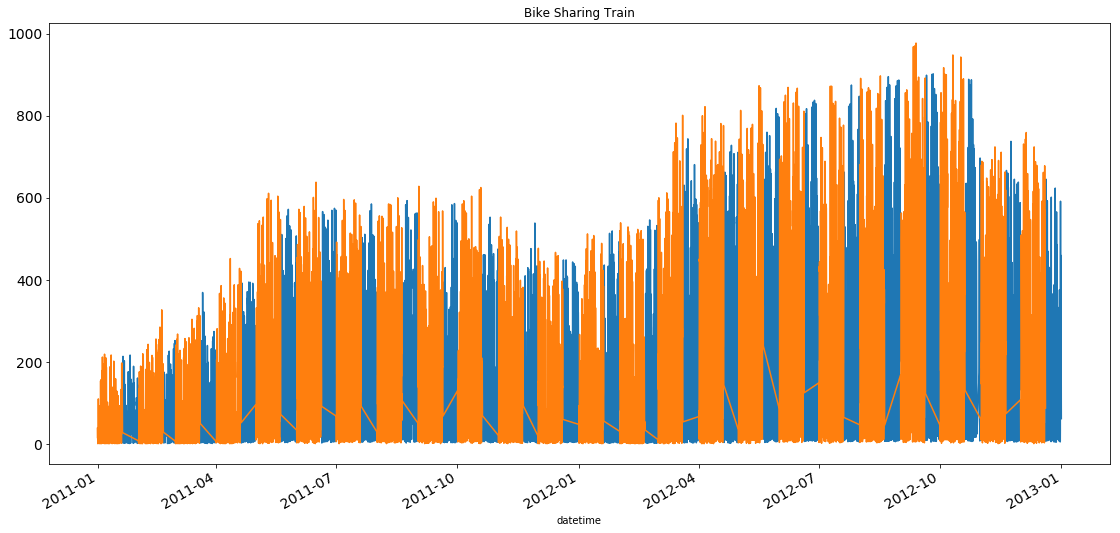

In [20]:
dTrain = pd.read_csv('data/train.csv') # 1 au 19 du mois (avec count)
dTrain.datetime = pd.to_datetime(dTrain.datetime)
dTrain.index = dTrain.datetime

dTest = pd.read_csv('data/test.csv') # 19 à fin du mois (sans count)
dTest.datetime = pd.to_datetime(dTest.datetime)
dTest.index = dTest.datetime

dTest["count"] = preds

dTest['count'].plot(figsize=(19,9), title="Bike Sharing Test", fontsize=14)
dTrain['count'].plot(figsize=(19,9), title="Bike Sharing Train", fontsize=14)
plt.show()

# 4. Création de submission.csv

On crée un fichier de submission en utilisant le template utilisé par Kaggle en y ajoutant nos résultats pour count.
On sauvegarde ce fichier dans le dossier /submissions/ avec un nom daté.

In [21]:
import datetime
from time import strftime
now = datetime.datetime.now()
now = datetime.datetime.strftime(now, '%Y-%m-%d_%H:%M')

submission = pd.read_csv('data/submission.csv')
submission["count"] = preds

submission.to_csv('submissions/submission_'+now, index=False)